# 05_model_vit_or_efficientnet.ipynb (Fixed)

EfficientNet uses `Rescaling` instead of `Lambda(preprocess_input)` to avoid shape inference errors.


In [ ]:
from google.colab import drive
# This command will prompt you to authorize Colab to access your Drive
drive.mount('/content/drive')
print("Google Drive Mounted Successfully!")

Mounted at /content/drive
Google Drive Mounted Successfully!


In [ ]:
import os, json, time, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models

PROCESSED_DIR = "/content/drive/MyDrive/My Drive SE4050_Project data processed"
MODEL_DIR     = "models"
RESULTS_DIR   = "results"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

CLASS_NAMES = ["Closed_Eyes","Open_Eyes","Yawn","No_Yawn"]
num_classes = len(CLASS_NAMES)

MODEL_FAMILY = "efficientnet"  # or 'vit'
TARGET_SIZE = (224, 224)

tf.random.set_seed(42); np.random.seed(42)
print("TensorFlow:", tf.__version__, "| Model family:", MODEL_FAMILY, "| Target:", TARGET_SIZE)


TensorFlow: 2.19.0 | Model family: efficientnet | Target: (224, 224)


In [ ]:
X_train = np.load(f"{PROCESSED_DIR}/X_train.npy")
y_train = np.load(f"{PROCESSED_DIR}/y_train.npy")
X_val   = np.load(f"{PROCESSED_DIR}/X_val.npy")
y_val   = np.load(f"{PROCESSED_DIR}/y_val.npy")
X_test  = np.load(f"{PROCESSED_DIR}/X_test.npy")
y_test  = np.load(f"{PROCESSED_DIR}/y_test.npy")

print("Shapes:")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_val  :", X_val.shape,   " y_val  :", y_val.shape)
print("  X_test :", X_test.shape,  " y_test :", y_test.shape)


Shapes:
  X_train: (1726, 64, 64, 3)  y_train: (1726,)
  X_val  : (496, 64, 64, 3)  y_val  : (496,)
  X_test : (245, 64, 64, 3)  y_test : (245,)


In [ ]:
classes = np.arange(num_classes)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weights = {int(i): float(w) for i,w in enumerate(class_weights)}
class_weights


{0: 0.9988425925925926,
 1: 0.9988425925925926,
 2: 1.0011600928074247,
 3: 1.0011600928074247}

In [ ]:
def build_efficientnet_classifier(num_classes, target_size=(224,224)):
    resize = layers.Resizing(target_size[0], target_size[1])
    rescale = layers.Rescaling(1./127.5, offset=-1.0)  # [0,255] -> [-1,1]
    base = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",
                                                input_shape=(target_size[0], target_size[1], 3))
    base.trainable = False

    inputs = layers.Input(shape=X_train.shape[1:])
    x = resize(inputs)
    x = rescale(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs, name="efficientnet_b0_cls")
    return model, base

In [ ]:
def mlp(x, hidden_units, dropout=0.0):
    for units in hidden_units:
        x = layers.Dense(units, activation='gelu')(x)
        x = layers.Dropout(dropout)(x)
    return x

def build_vit_classifier(num_classes, image_size=(224,224), patch_size=16,
                         projection_dim=192, transformer_layers=6, num_heads=3,
                         mlp_head_units=[256,128]):
    inputs = layers.Input(shape=X_train.shape[1:])  # (H0,W0,3)
    x = layers.Resizing(image_size[0], image_size[1])(inputs)

    patches = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(x)
    h, w = image_size[0] // patch_size, image_size[1] // patch_size
    num_patches = h * w
    x = layers.Reshape((num_patches, projection_dim))(patches)  # (B, N, D)

    pos_emb = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_encoding = pos_emb(positions)  # (N, D)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)  # (1, N, D)
    x = x + pos_encoding  # broadcast add

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attn, x])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[projection_dim*4, projection_dim], dropout=0.1)
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = mlp(x, mlp_head_units, dropout=0.2)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs, name="vit_classifier_simple")
    return model


In [7]:
if MODEL_FAMILY == "efficientnet":
    model, base = build_efficientnet_classifier(num_classes, TARGET_SIZE)
else:
    model = build_vit_classifier(num_classes, image_size=TARGET_SIZE)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnet_b0_cls"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

run_id = time.strftime("%Y%m%d-%H%M%S") + f"_{MODEL_FAMILY}"
ckpt_path = f"{MODEL_DIR}/{MODEL_FAMILY}_best_{run_id}.keras"
log_dir   = f"{RESULTS_DIR}/logs_{run_id}"

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    TensorBoard(log_dir=log_dir)
]

print("Checkpoint:", ckpt_path)
print("Logs     :", log_dir)


Checkpoint: models/efficientnet_best_20251011-114440_efficientnet.keras
Logs     : results/logs_20251011-114440_efficientnet


In [11]:
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15 if MODEL_FAMILY=="efficientnet" else 25,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2324 - loss: 1.4070
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to models/efficientnet_best_20251011-114440_efficientnet.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 205s 7s/step - accuracy: 0.2329 - loss: 1.4068 - val_accuracy: 0.2500 - val_loss: 1.4004 - learning_rate: 0.0010
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2603 - loss: 1.4050
Epoch 2: val_accuracy did not improve from 0.25000
27/27 ━━━━━━━━━━━━━━━━━━━━ 159s 6s/step - accuracy: 0.2605 - loss: 1.4050 - val_accuracy: 0.2500 - val_loss: 1.4008 - learning_rate: 0.0010
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2391 - loss: 1.4079
Epoch 3: val_accuracy did not improve from 0.25000
27/27 ━━━━━━━━━━━━━━━━━━━━ 158s 6s/step - accuracy: 0.2397 - loss: 1.4076 - val_accuracy: 0.2500 - val_loss: 1.4034 - learning_rate: 0.0010
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2724 - loss: 1.4033
Epoch 4: val_accu

In [13]:
history2 = None
if MODEL_FAMILY == "efficientnet":
    for layer in base.layers[-30:]:
        layer.trainable = True
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    history2 = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=25,
        batch_size=64,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2164 - loss: 1.4483
Epoch 1: val_accuracy did not improve from 0.25000
27/27 ━━━━━━━━━━━━━━━━━━━━ 221s 8s/step - accuracy: 0.2168 - loss: 1.4477 - val_accuracy: 0.2500 - val_loss: 1.4040 - learning_rate: 1.0000e-05
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2670 - loss: 1.4131
Epoch 2: val_accuracy did not improve from 0.25000
27/27 ━━━━━━━━━━━━━━━━━━━━ 189s 7s/step - accuracy: 0.2663 - loss: 1.4131 - val_accuracy: 0.2500 - val_loss: 1.4049 - learning_rate: 1.0000e-05
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2752 - loss: 1.4015
Epoch 3: val_accuracy did not improve from 0.25000
27/27 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.2747 - loss: 1.4016 - val_accuracy: 0.2500 - val_loss: 1.4042 - learning_rate: 1.0000e-05
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2529 - loss: 1.4084
Epoch 4: val_accuracy did not improve from 0.25000
27/27 ━━━━━━━━━━━━━━━━━━━━ 200s 

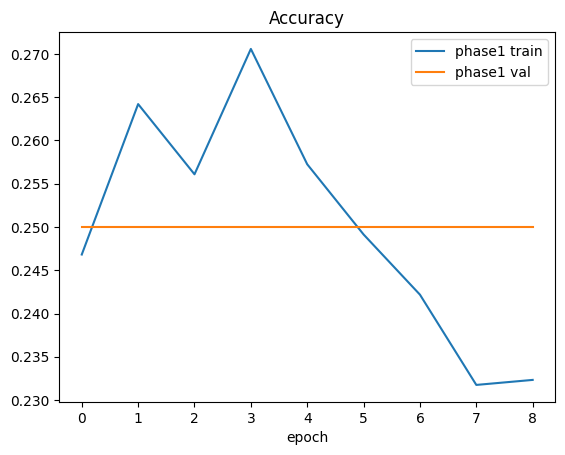

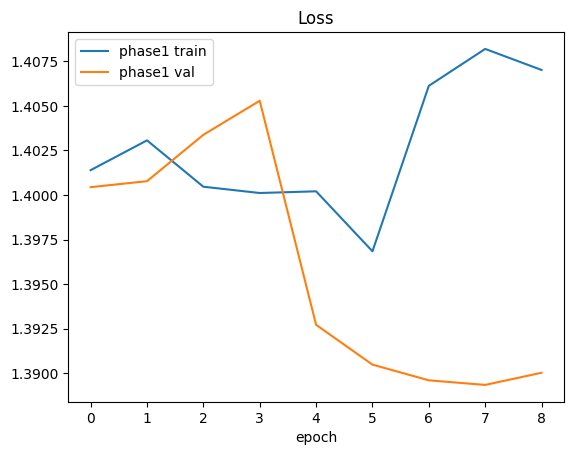

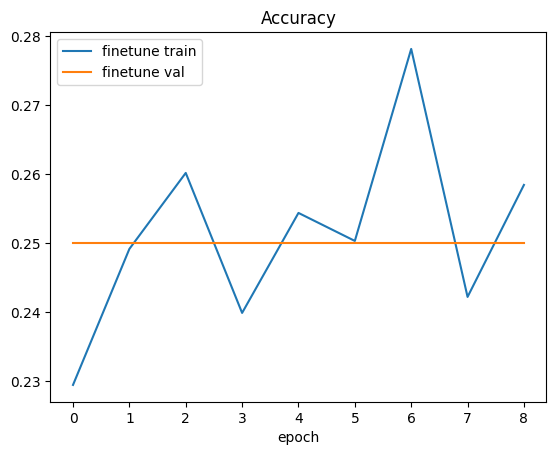

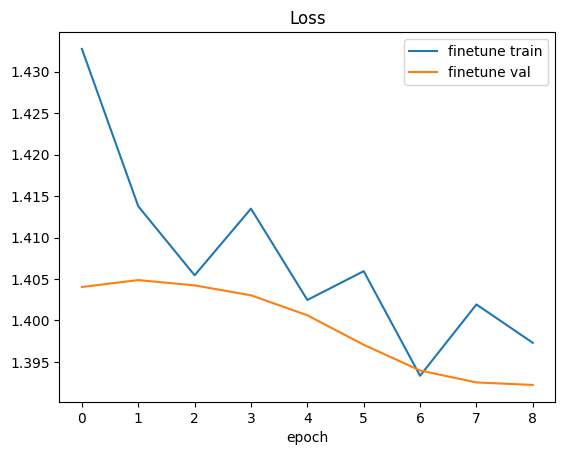

In [14]:
def plot_hist(h, label):
    if h is None: return
    plt.figure(); plt.plot(h.history["accuracy"], label=f"{label} train"); plt.plot(h.history["val_accuracy"], label=f"{label} val"); plt.title("Accuracy"); plt.xlabel("epoch"); plt.legend(); plt.show()
    plt.figure(); plt.plot(h.history["loss"], label=f"{label} train"); plt.plot(h.history["val_loss"], label=f"{label} val"); plt.title("Loss"); plt.xlabel("epoch"); plt.legend(); plt.show()

plot_hist(history1, "phase1")
plot_hist(history2, "finetune")


Test accuracy: 0.2531


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 Closed_Eyes       0.00      0.00      0.00        61
   Open_Eyes       0.00      0.00      0.00        61
        Yawn       0.25      1.00      0.40        62
     No_Yawn       0.00      0.00      0.00        61

    accuracy                           0.25       245
   macro avg       0.06      0.25      0.10       245
weighted avg       0.06      0.25      0.10       245



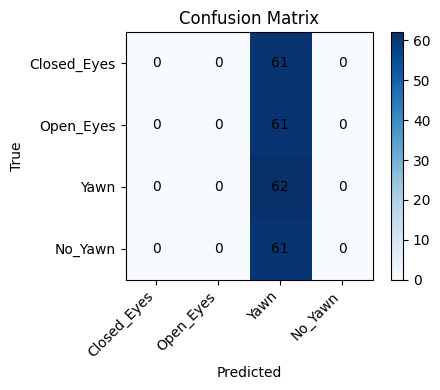

Saved report to: results/efficientnet_report_20251011-114440_efficientnet.txt


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(num_classes)); ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticks(range(num_classes)); ax.set_yticklabels(CLASS_NAMES)
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix")
plt.colorbar(im, ax=ax); plt.tight_layout(); plt.show()

report_path = f"{RESULTS_DIR}/{MODEL_FAMILY}_report_{run_id}.txt"
with open(report_path, "w") as f:
    f.write(f"Test accuracy: {test_acc:.4f}\n\n")
    f.write(classification_report(y_test, y_pred, target_names=CLASS_NAMES))
print("Saved report to:", report_path)


In [16]:
final_path = f"{MODEL_DIR}/{MODEL_FAMILY}_final_{run_id}.keras"
model.save(final_path)
with open(f"{MODEL_DIR}/labels.json","w") as fp:
    json.dump({i:c for i,c in enumerate(CLASS_NAMES)}, fp)

print("Saved model to:", final_path)
print("Saved labels to: models/labels.json")


Saved model to: models/efficientnet_final_20251011-114440_efficientnet.keras
Saved labels to: models/labels.json


In [17]:
import cv2
def predict_image_generic(path, model, target_size=(224,224)):
    img = cv2.imread(path)
    if img is None: raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    x = (img/255.0).astype("float32")
    x = np.expand_dims(x, axis=0)
    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    return {"class": CLASS_NAMES[idx], "confidence": float(probs[idx]), "probs": probs.tolist()}

# Example:
# res = predict_image_generic("data/sample/your_image.jpg", model, target_size=TARGET_SIZE)
# res
